(example_3)=
# Example 3: A multi-armed bandit task with independent reward and punishments

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_2_Input_node_volatility_coupling.ipynb)

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !pip install pyhgf

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
from scipy.stats import norm

from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF

In this notebook, we are going to illustrate how to fit behavioural responses from a two-armed bandit task when the rewards and punishments are independent. The task is similar to what was used in {cite:p}`Pulcu2017`. This will also illustrate how to use missing observations and the impact it has on the belief trajectories.

Because the rewards and punishments are independent, we simulate the task using four binary HGFs, assuming that on both arms, both rewards and punishments are evolving independently.

```{note}
While the binary HGF is a special case of the categorical HGF where the number of categories is set to 2, the categorical HGF adds a volatility coupling between the binary branch (see {ref}`categorical_hgf`). Therefore a categorical HGF would not be suitable here as we want every branch of the network to evolve independently.
```

I0000 00:00:1700494170.418168    3049 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Initializing a network with custom node structure.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.


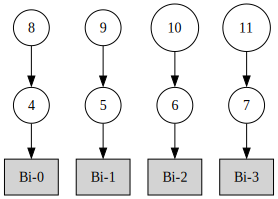

In [3]:
two_armed_bandit_hgf = (
    HGF(model_type=None)
    .add_input_node(kind="binary", input_idxs=0)
    .add_input_node(kind="binary", input_idxs=1)
    .add_input_node(kind="binary", input_idxs=2)
    .add_input_node(kind="binary", input_idxs=3)
    .add_value_parent(children_idxs=[0])
    .add_value_parent(children_idxs=[1])
    .add_value_parent(children_idxs=[2])
    .add_value_parent(children_idxs=[3])
    .add_value_parent(children_idxs=[4], tonic_volatility=-1.0)
    .add_value_parent(children_idxs=[5], tonic_volatility=-1.0)
    .add_value_parent(children_idxs=[6], tonic_volatility=-1.0)
    .add_value_parent(children_idxs=[7], tonic_volatility=-1.0)
    .init()
)
two_armed_bandit_hgf.plot_network()

## Task structure
We start with a simple task structure where contingencies (i.e. the probability that a given armed bandit is associated with a win/loss) alternate between `0.2`, `0.5` and `0.8`. The rate of change in contingencies can be fast (i.e. high volatility blocks) or slow (i.e. low volatility blocks).

In [4]:
# three levels of probability
high_prob, chance, low_prob = 0.8, 0.5, 0.2

# create blocks of contingencies
stable_contingencies = np.array([low_prob, high_prob]).repeat(20)
volatile_contingencies = np.tile(np.array([low_prob, high_prob]).repeat(10), 3)
chance_contingencies = np.array(chance).repeat(40)

In [5]:
# create sequences of blocks for the different cases
win_arm1 = np.concatenate([stable_contingencies, chance_contingencies, volatile_contingencies])
loss_arm1 = np.concatenate([volatile_contingencies, chance_contingencies, stable_contingencies])
win_arm2 = np.concatenate([chance_contingencies, stable_contingencies, volatile_contingencies])
loss_arm2 = np.concatenate([chance_contingencies, volatile_contingencies, stable_contingencies])

In [6]:
# sample trial level outcomes from the sequences
u_win_arm1 = np.random.binomial(n=1, p=win_arm1)
u_loss_arm1 = np.random.binomial(n=1, p=loss_arm1)
u_win_arm2 = np.random.binomial(n=1, p=win_arm2)
u_loss_arm2 = np.random.binomial(n=1, p=loss_arm2)

This gives the following task structure:

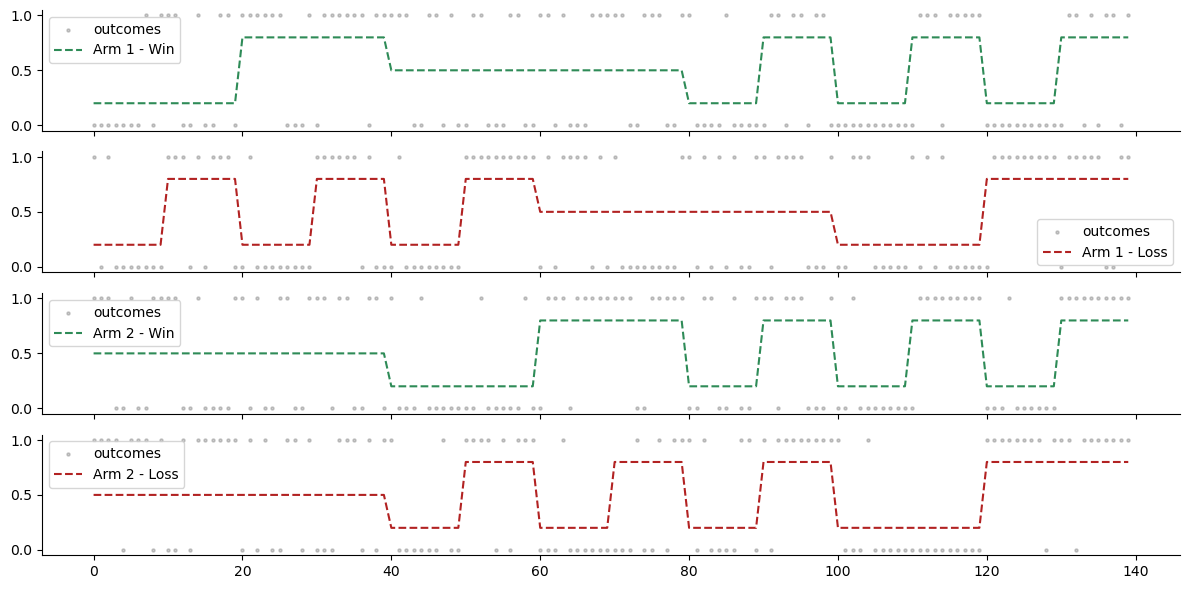

In [7]:
# trial numbers
trials = np.arange(len(win_arm1))

_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True)

for i, u, p, label, color in zip(
    range(4),
    [u_win_arm1, u_loss_arm1, u_win_arm2, u_loss_arm2], 
    [win_arm1, loss_arm1, win_arm2, loss_arm2], 
    ["Arm 1 - Win", "Arm 1 - Loss", "Arm 2 - Win", "Arm 2 - Loss"],
    ["seagreen", "firebrick", "seagreen", "firebrick"]
):
    axs[i].scatter(trials, u, label="outcomes", alpha=.4, s=5, color="gray")
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend()
plt.tight_layout()
sns.despine();

## Simulate a dataset

We can simlate our vector of observation. This is a two dimentional matrix with input observations for the four components of our model.

In [8]:
u = np.array([u_win_arm1, u_loss_arm1, u_win_arm2, u_loss_arm2])

From there, it is straightforward to feed these observations to our four branches HGF to retrieve the trajectories.

```{note}
Here, we are providing all the outcomes from all trials. This is not how the task would work as the participant will only be presented with the outcomes from the armed bandit chosen, and we are not using responses from the participant yet. See also {ref}`custom_response_functions` for details on the observations `u` and the responses `y`.
```

In [9]:
two_armed_bandit_hgf.input_data(input_data=u.T);

Adding 140 new observations.


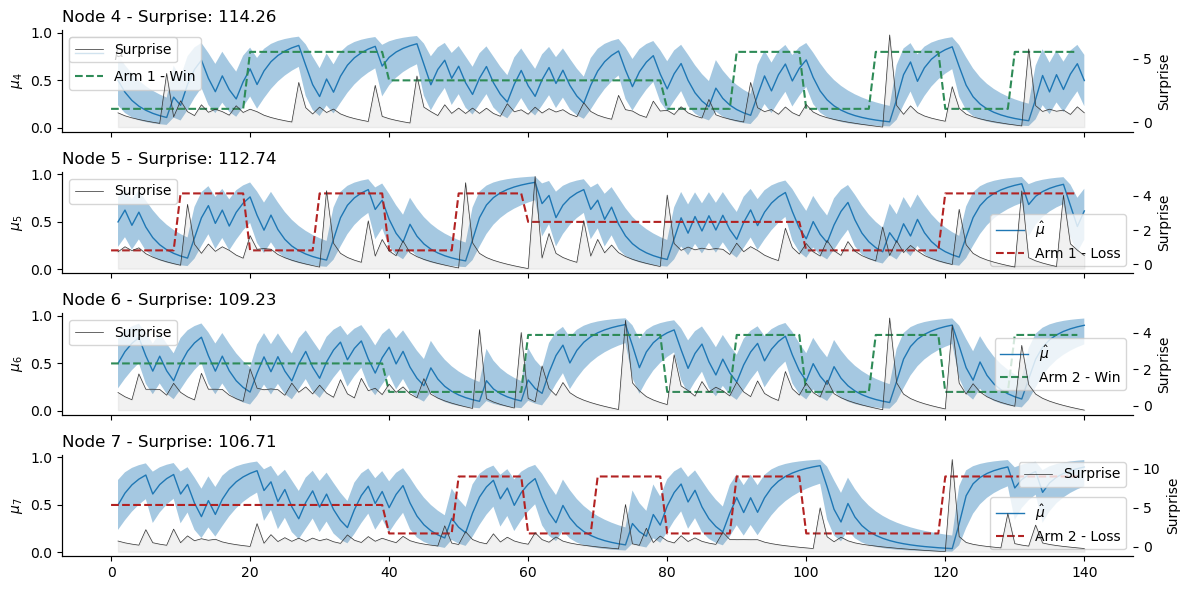

In [10]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_armed_bandit_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_armed_bandit_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_armed_bandit_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_armed_bandit_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [win_arm1, loss_arm1, win_arm2, loss_arm2], 
    ["Arm 1 - Win", "Arm 1 - Loss", "Arm 2 - Win", "Arm 2 - Loss"],
    ["seagreen", "firebrick", "seagreen", "firebrick"]
):
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend()

plt.tight_layout()
sns.despine();

## Simulate responses from a participant
Using the beliefs trajectories recovered from the model fits above, we can simulate responses from a participant that would use the same parametrisation of beliefs update (especially the same `tonic_volatility` here).

### Decision rule

The probability of chosing the arm $A$ given the probability of wining on both arms ${W_a; W_b}$ and the probability of loosing on both arms ${L_a; L_b}$, is given by the following softmax decision function:

$$
p(A) = \frac{e^{\beta(W_a-L_a)}}{e^{\beta(W_a-L_a)} + e^{\beta(W_b-L_b)}}
$$

where $\beta$ is the inverse temperature parameter.

In [11]:
beta = 1.0
w_a = two_armed_bandit_hgf.node_trajectories[4]["expected_mean"]
l_a = two_armed_bandit_hgf.node_trajectories[5]["expected_mean"]
w_b = two_armed_bandit_hgf.node_trajectories[6]["expected_mean"]
l_b = two_armed_bandit_hgf.node_trajectories[7]["expected_mean"]

p_a = np.exp(beta * (w_a-l_a)) / ( np.exp(beta * (w_a-l_a)) + np.exp(beta * (w_b-l_b)))

Using these probabilities, we can infer which arm was selected at each trial and filter the inputs that are presented to the participant. Because it would be too chaotic to provide the information about the four hidden states at each trial, here the participant is only presented with the information about the arm that was selected. Therefore, when arm $A$ is selected, the inputs from arm $B$ are set to `jnp.nan` and will be ignored during the node update.

In [12]:
u = u.astype(float)
u[:2, p_a<=.5] = np.nan
u[2:, p_a>.5] = np.nan

```{note}
Missing inputs are used to indicate an absence of observation from the agent's point of view and should not be used for missing records or excluded trials. When an input is labelled as missing, we use the total volatility at the parents' level to decrease their precision as a function of time elapsed, but the means are still the same. Because this functionality implies an overhead of checks, it is deactivated by default. To activate it, we need to set `allow_missing_iputs` to `True` upon model creation.
```

Initializing a network with custom node structure.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.


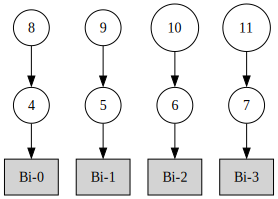

In [13]:
two_armed_bandit_missing_inputs_hgf = (
    HGF(model_type=None, allow_missing_inputs=True)
    .add_input_node(kind="binary", input_idxs=0)
    .add_input_node(kind="binary", input_idxs=1)
    .add_input_node(kind="binary", input_idxs=2)
    .add_input_node(kind="binary", input_idxs=3)
    .add_value_parent(children_idxs=[0])
    .add_value_parent(children_idxs=[1])
    .add_value_parent(children_idxs=[2])
    .add_value_parent(children_idxs=[3])
    .add_value_parent(children_idxs=[4], tonic_volatility=-1.0)
    .add_value_parent(children_idxs=[5], tonic_volatility=-1.0)
    .add_value_parent(children_idxs=[6], tonic_volatility=-1.0)
    .add_value_parent(children_idxs=[7], tonic_volatility=-1.0)
    .init()
)
two_armed_bandit_hgf.plot_network()

In [14]:
two_armed_bandit_missing_inputs_hgf.input_data(input_data=u.T);

Adding 140 new observations.


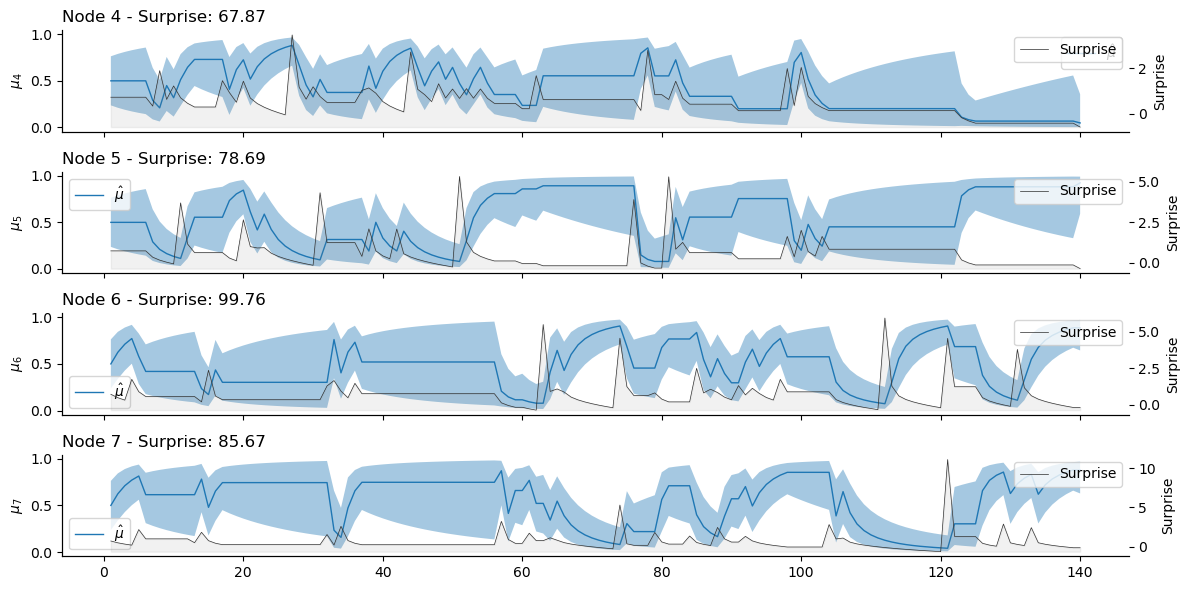

In [15]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_armed_bandit_missing_inputs_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_armed_bandit_missing_inputs_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_armed_bandit_missing_inputs_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_armed_bandit_missing_inputs_hgf.plot_nodes(node_idxs=7, axs=axs[3])

plt.tight_layout()
sns.despine();

We can now see from the plot above that the branches of the networks are now only updated if the participant actually chose the corresponding arm. Otherwise the expected probability remains the same but the uncertainty will increase over time.

## Parameter recovery

## Hierarchical modelling

## System configuration

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Mon Nov 20 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

pyhgf : 0.0.12
jax   : 0.4.16
jaxlib: 0.4.16

numpy     : 1.22.0
matplotlib: 3.7.1
seaborn   : 0.12.2
sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
pymc      : 5.9.1
arviz     : 0.16.1

Watermark: 2.4.3

